# Harris Corner Detection

## Overview

### Motivation

* Object detection
* Object recognition
* Image alignment 
* Image stitching (panoramics)
* Stereo matching
* Camera extrinsics (pose = position and orientation)
* Triangulation to identify the location of points
* Object tracking

### Features

* One of the foundations of CV is feature detection and matching
* We need distinctive points (or patches) within images
* What is a distinctive patch?
* Sometimes called _corners_, _interest points_, or _keypoint features_, or simply _keypoints_

#### Edges

* Also, edges
* Distinctive parts of images
* May be grouped into _curves_ or _straight line segments_
* May help find _vanishing points_ (the line at infinity)

### Intuition

* Homogeneous regions aren't good (clouds, solid walls, etc.)
* Lines aren't good (unclear where you are on the line)
    * Even if lines are curved, they're not good
    * Keep in mind the camera may rotate

### Feature Tracking

* Two approaches
* First, feature moves a little from one frame to another
    * Can use tracking approaches
    * Kalman filter and other state space trackers, possibly
    * Correlation and least squares techniques
* Second, feature could be anywhere
    * Possibly through some type of transform
    * Match based on local appearance

## Feature Detection and Matching

### Organization
Four stages
1. Feature detection
1. Feature description
1. Feature matching
1. Feature tracking

We will go through this slowly with a focus on feature detection and less emphasis on edges

Our focus, in particular, will be on
* Harris Corner Detectors
* Scale Invariant Feature Transform (SIFT)
* ORB
    * Based on FAST and BRIEF
* Please see the original papers
    * The first is short

# Harris Corner Detectors

* Original paper was more interested in edges than corners
* Note: _edgel_ is a pixel that contains an edge
    * Also sometimes simply called _edge pixels_
* Corners were a means to detecting edges
* However, corners are great features
* Edges, in general, are not great features because you can't tell where along the edge you are - at least from a local patch


## Moravec Corner Detector
* Not particularly important or useful since Harris corner is detector
* However, was the motivation for the Harris corner detector
* Consider a local _patch_ or _window_ of an image
* Consider what happens when this patch is shifted by a pixel in some direction
    * How similar is the shifted patch to the original?
* We can quantify this with the (weighted) summed square difference (SSD)
\begin{align*}
    E(x,y) &= \sum_{u,v} w(u,v) |I(u+x,v+y) - I(u,v)|^2
    \hspace{100em}
\end{align*}
* Note that when we are comparing a patch to a shifted patch from the same image, the book calles this the _auto-correlation function_ or _autocorrelation surface_
    * However, it is emphatically not an autocorrelation function
    \begin{align*}
        r(x,y) &= \frac{1}{N_p}\sum_{u,v} I(x+u,y+v) I(u,v)
        \hspace{100em}
    \end{align*}
    where $N_p$ is the number of pixels in the image patch
    * It is related to the autocorrelation, but it is not the autocorrelation itself
    \begin{align*}
        E(x,y) &= \sum_{u,v} w(u,v) |I(u+x,v+y) - I(u,v)|^2 \\
        &= \sum_{u,v} w(u,v) \left( I(u+x,v+y)^2 - 2I(u+x,v+y)I(u,v) + I(u,v)^2 \right) \\
        &= \sum_{u,v} w(u,v) I(u+x,v+y)^2 - 2\sum_{u,v} w(u,v)I(u+x,v+y)I(u,v) + \sum_{u,v} w(u,v)I(u,v)^2 \\
        &= \sum_{u,v} w(u,v) I(u+x,v+y)^2 - 2r(x,y) + \sum_{u,v} w(u,v)I(u,v)^2 \\
        &= s - 2r(x,y) + t
        \hspace{100em}
    \end{align*}
    where $s$ and $t$ are the sums of the weighted squared pixel values in the shifted and original patches, respectively
        * Note that $s$ and $t$ are constants and do not depend on $x$ and $y$
        * Thus, the SSD is essentially an affine transformation of the autocorrelation surface
        \begin{align*}
            E(x,y) &= m r(x,y) + b 
            \hspace{100em}
        \end{align*}
        where $m$ and $b$ are constants ($m = -2$ and $b = s + t$)
* Perhaps we could look for patches that are distinctive such that a small shift causes a large change in the SSD
* We could then evaluate the entire image looking for patches where $E(x,y)$ is large for small shifts in $x$ and $y$

### Various Types of Patches
* Uniform patches
    * Shift in any direction causes a small change
* Edges
    * If we straddle an edge, a shift along the edge will cause a small change
    * Shift perpendicular to the edge will cause a large change
* Corners
    * If we have a corner, a small shift will cause a large change in any direction
 
### Moravec Detection
* Try the following $(x,y)$ shifts: $[(1,0),(1,1),(0,1),(-1,1)]$
    * Down, Down-right, Right, Up-right
* Of all of these look determine the smallest SSD
* Apply across the entire image
* Look for local maxima above some threshold

## Harris Corner Detection

* Motivated by shortcomings in Moravec's corner detector
* Problems and solutions as follows

### Response is aniostropic
* Only discrete shifts at every 45 degrees is considered
* Key idea: images are spatially sampled representations of continuous surfaces
* If think of the image as a continuous surface, rather than a grid of pixels, we can do more mathematically
* Consider a first order Taylor series approximation to the energy intensity

\begin{align*}
    E(x,y) &= \sum_{u,v} w(u,v) |I(u+x,v+y) - I(u,v)|^2\\
        &\approx \sum_{u,v} w(u,v) |I(u,v) + D_x(u,v)x + D_y(u,v)y - I(u,v)|^2
    \hspace{100em}
\end{align*}

### Derivatives
* You know of several methods of "calculating" image derivatives
    * Simple methods without much smoothing
    * Gaussian derivatives
* We can represent the gradient evaluated at $(x,y)$ as 

\begin{align*}
    \nabla I(x,y) &= 
        \begin{bmatrix} 
            \frac{\partial I(x,y)}{\partial x} \\
            \frac{\partial I(x,y)}{\partial y} 
        \end{bmatrix}
        =
        \begin{bmatrix} 
            D_x \\
            D_y  
        \end{bmatrix}
    \hspace{100em}
\end{align*}

* This could be estimated with a variety of linear filters
    * Gaussian derivative filter
    * Sobel filter
    * And others
* Harris chose Sobel

### Taylor Series Approximation

\begin{align*}
    E(x,y) &= \sum_{u,v} w(u,v) |I(u+x,v+y) - I(u,v)|^2\\
        &\approx \sum_{u,v} w(u,v) |I(u,v) + D_x(u,v)x + D_y(u,v)y - I(u,v)|^2\\
        &= \sum_{u,v} w(u,v) |D_x(u,v)x + D_y(u,v)y|^2\\
        &= \sum_{u,v} w(u,v) \left[(D_x(u,v)x)^2 + 2D_x(u,v)xD_y(u,v)y + (D_y(u,v)y)^2\right] 
    \hspace{100em}  
\end{align*}

Let

\begin{align*}
    I \otimes w &\triangleq \sum_{u,v} w(u,v) I(u,v)
    \hspace{100em}
\end{align*}    

Then

\begin{align*}
E(x,y) &= \left[\sum_{u,v} w(u,v) (D_x(u,v)x)^2\right]  + \left[\sum_{u,v} w(u,v) 2 D_x(u,v)x D_y(u,v)y\right] + \left[\sum_{u,v} w(u,v) (D_y(u,v)y)^2\right] \\
    &= x^2 \left[\sum_{u,v} w(u,v) (D_x(u,v))^2\right]  + 2 xy \left[\sum_{u,v} w(u,v) D_x(u,v) D_y(u,v)\right] + y^2 \left[\sum_{u,v} w(u,v) (D_y(u,v))^2\right] \\
    &= \left(D_x^2 \otimes w\right) x^2 + 2 \left(D_x D_y \otimes w\right)xy + \left(D_y^2 \otimes w\right) y^2\\
    &= Ax^2 + 2Cxy + By^2 \\
    &= \begin{bmatrix} x & y \end{bmatrix}
    \begin{bmatrix} 
        A & C \\
        C & B 
    \end{bmatrix}
    \begin{bmatrix}
        x \\
        y
    \end{bmatrix}\\
    &= \begin{bmatrix} x & y \end{bmatrix}
    M
    \begin{bmatrix}
        x \\
        y
    \end{bmatrix}
    \hspace{100em}
\end{align*}

where

\begin{align*}
    A &= D_x^2 \otimes w & 
    C &= (D_x D_y) \otimes w &
    B &= D_y^2 \otimes w
    \hspace{100em}
\end{align*}

and

\begin{align*}
    M &\triangleq 
        \begin{bmatrix} 
        A & C \\
        C & B 
    \end{bmatrix} 
    \hspace{100em}
\end{align*}

### Other Problems
* Signal is noisy
    * Use a smooth, circular window
    * Of course, Gaussian
   
### Operator is to sensitive to edges
* Harris went through some work to justify a figure of merit that is calculated from $M$
* He landed on $R = \mathrm{Det}(M) - k \mathrm{Tr}^2(M)$ where
\begin{align*}
    \mathrm{Det}(M) &= AB - C^2 && \text{Determinant} \\
    \mathrm{Tr}(M)  &= A + B    && \text{Trace}
    \hspace{100em}
\end{align*}
    * $k$ is a constant
* He didn't specify what value of $k$ one should use, or how to determine it

### Gradient Outer Product?

* This is similar to an outer product of the gradient with itself

\begin{align*}
    \nabla I \nabla I^T &=
    \begin{bmatrix} 
        D_x \\
        D_y
    \end{bmatrix}
    \begin{bmatrix} 
        D_x & D_y
    \end{bmatrix}
    =
    \begin{bmatrix} 
        D_x^2 & D_xD_y \\
        D_xD_y & D_y^2
    \end{bmatrix}
    \hspace{100em}
\end{align*}

* In fact, if there was no smoothing, it would be exactly this
* The rank of a vector outer product is 1
* However, $M$ has full rank
* How can this be?
* $M$ is not an outer product of the gradient
* The elements of $M$ ($A$, $B$, and $C$) are all weighted averages because of the smoothing
* This is critical
* Otherwise $M$ would be rank 1

### Hessian Matrix?
* Many people as evidenced by the literature believe the $M$ matrix is the Hessian
* It is not
* It is based on products of smoothed first-order derivatives
* Clear from the math in Harris' article
* The Hessian is a matrix of second-order derivatives


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PSUCV as pcv
import matplotlib

In [2]:
# Global variables

GOLDEN_RATIO = 1.61803398875
FIGURE_WIDTH = 15
FIGURE_HEIGHT = FIGURE_WIDTH / GOLDEN_RATIO

In [3]:
def add_colorbar(axes,color_map='gray'):
    images = axes.get_images()
    if len(images) > 0:
       vmin, vmax = images[0].get_clim()
    sm = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vmin,vmax=vmax),cmap=color_map)
    bb = np.array(axes.get_position().bounds)
    bb[0] += bb[2]*0.95
    bb[2] *= 0.05
    
    figure = axes.get_figure()
    barAxes = figure.add_axes(bb)
    figure.colorbar(sm,barAxes)

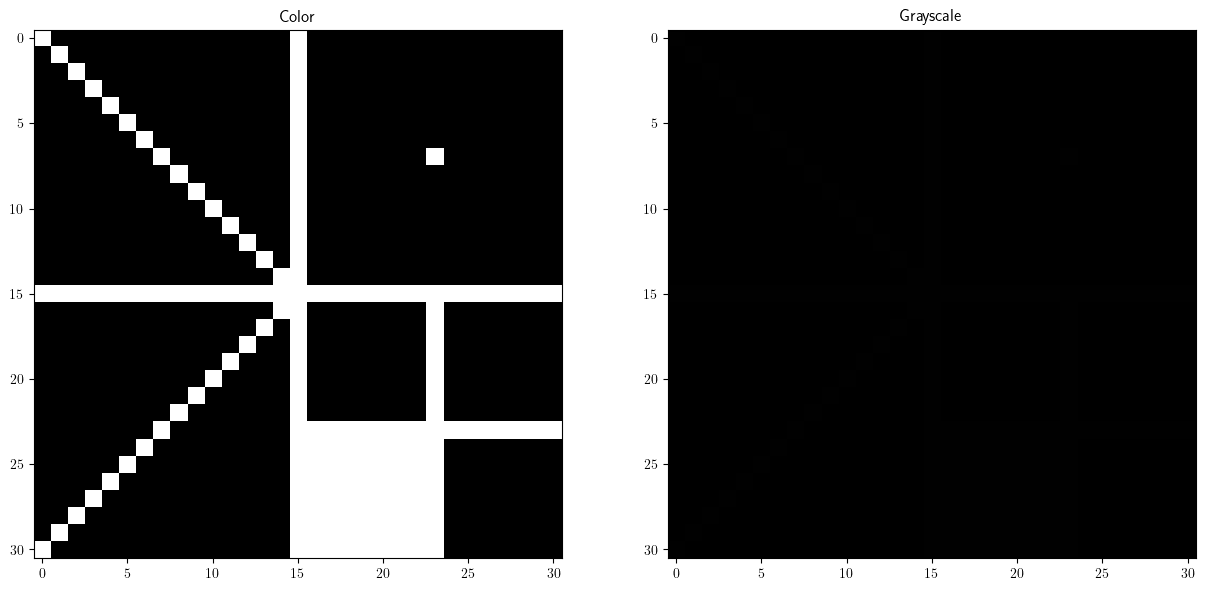

In [4]:
image = pcv.GetTestImage(nPixelsPerSide=31)

#imageGray = cv.GaussianBlur(imageGray, (3, 3), 0)
#src = cv.GaussianBlur(src, (3, 3), 0)
    
window_name = ('Sobel Demo - Simple Edge Detector')
scale  = 1
delta  = 0
kSize  = 3 # Must be 1, 3, 5, or 7
ddepth = cv.CV_64F

# Note that these derivatives are technically inverted (someone was probably slopping with the convolution vs correlation)
imageDx  = cv.Sobel(image, ddepth, 1, 0, ksize=kSize, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
imageDy  = cv.Sobel(image, ddepth, 0, 1, ksize=kSize, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
imageDdr = (imageDx + imageDy)/2.0
imageDdl = (imageDx - imageDy)/2.0
#cv.Sobel(gray, ddepth, 1, 1, ksize=kSize, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

figure = plt.figure(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT))
figure.clf()

axes = figure.add_subplot(121)
axes.imshow(image,cmap='gray')
axes.set_title('Color')

axes = figure.add_subplot(122)
axes.imshow(image,cmap='gray', vmin=0, vmax=255)
axes.set_title('Grayscale')

plt.show()

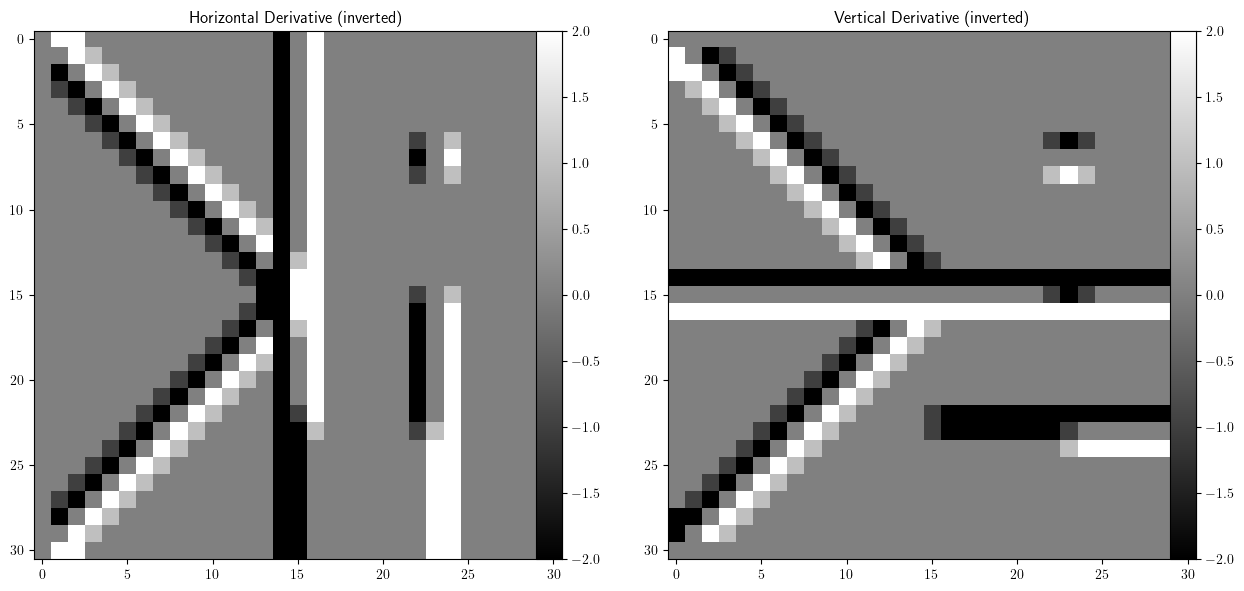

In [5]:
#%% Image Derivatives 
figure = plt.figure(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT))
figure.clf()

axes = figure.add_subplot(121)
axes.imshow(imageDx,cmap='gray_r', vmin=-2, vmax=2)
add_colorbar(axes)
axes.set_title('Horizontal Derivative (inverted)')

axes = figure.add_subplot(122)
axes.imshow(imageDy,cmap='gray_r', vmin=-2, vmax=2)
add_colorbar(axes)
axes.set_title('Vertical Derivative (inverted)')

plt.show()


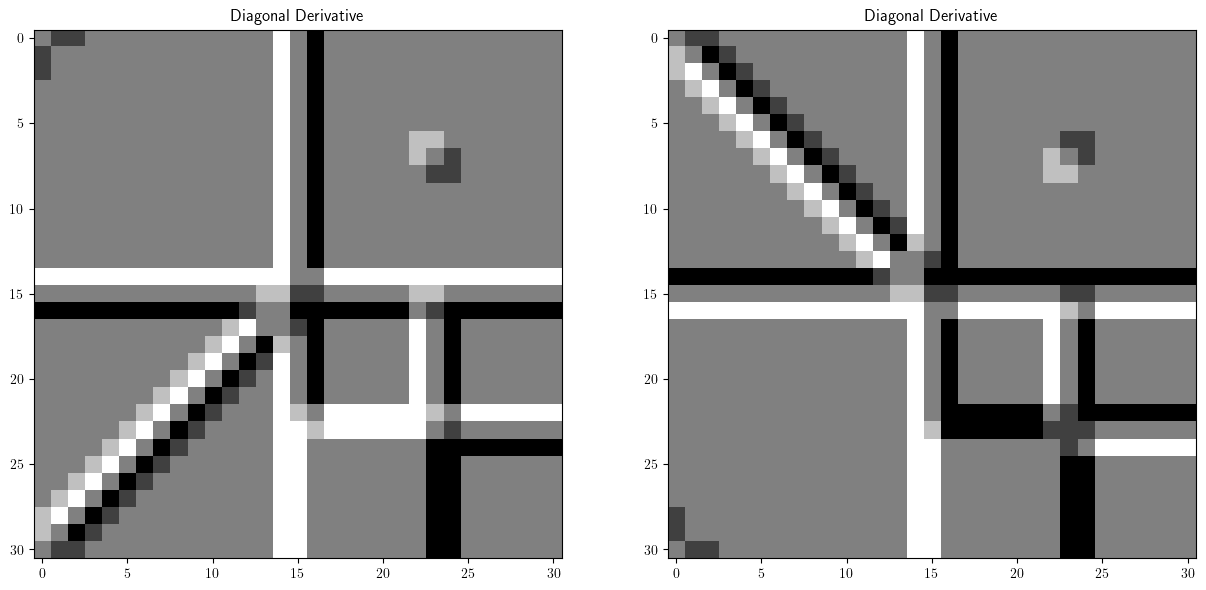

In [6]:
#%% Diagonal Derivatives
figure = plt.figure(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT))
figure.clf()

axes = figure.add_subplot(121)
axes.imshow(imageDdr,cmap='gray', vmin=-2, vmax=2)
axes.set_title('Diagonal Derivative')

axes = figure.add_subplot(122)
axes.imshow(imageDdl,cmap='gray', vmin=-2, vmax=2)
axes.set_title('Diagonal Derivative')
plt.show()

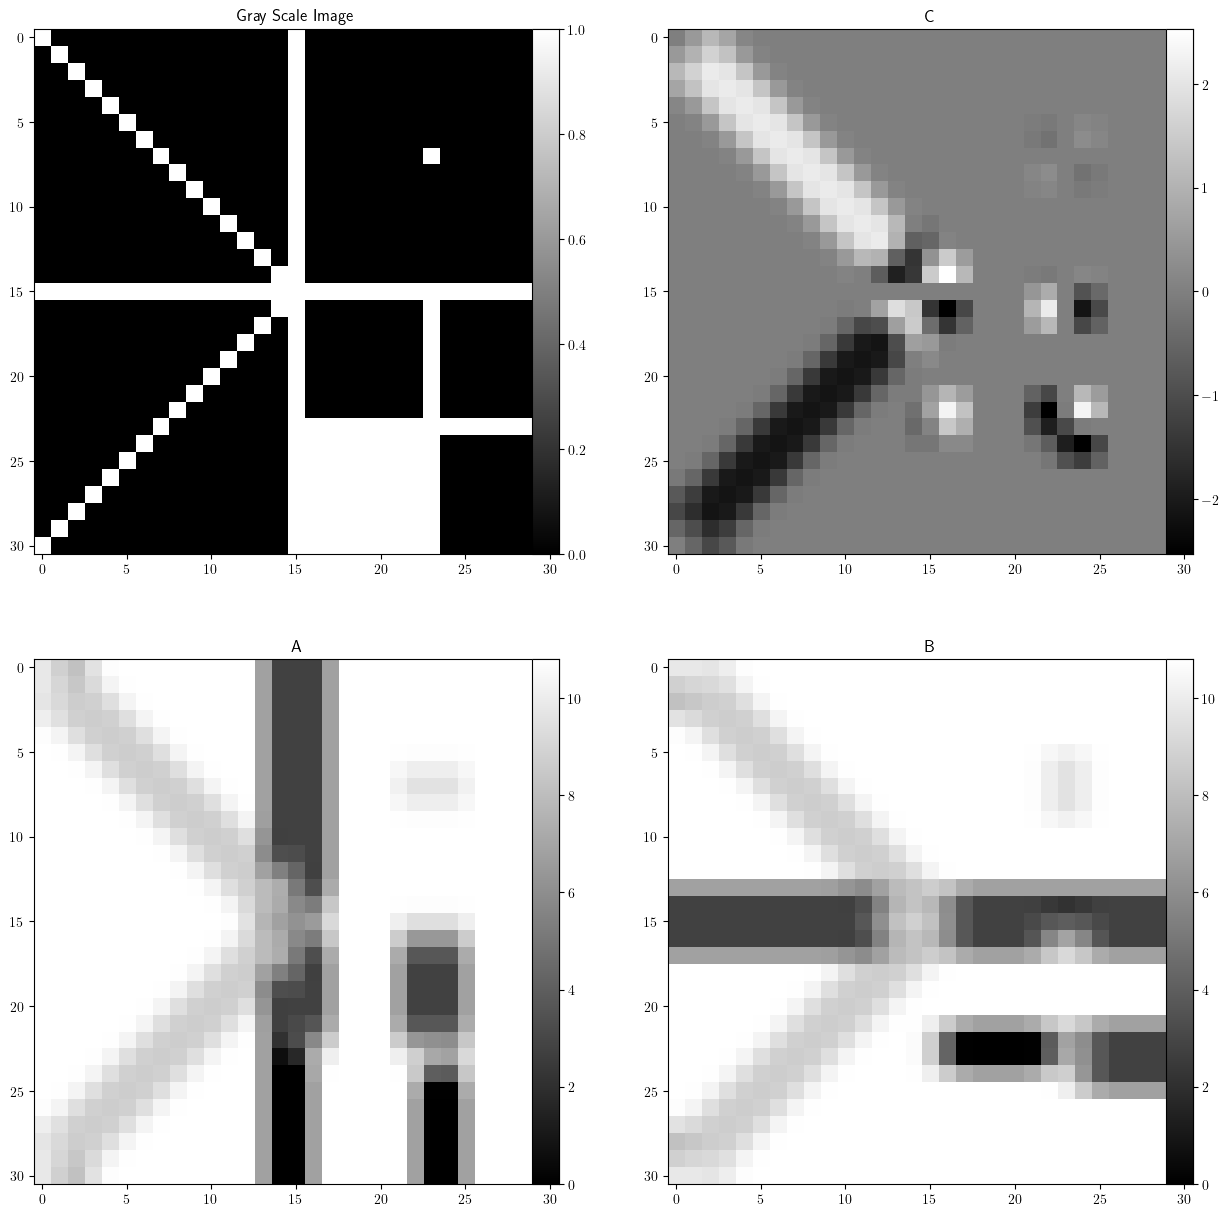

In [7]:
#%% Harris Detector Components
# Note that these are not scalars, but rather the elements of the three matrices
# at each pixel location
A = imageDx**2
B = imageDy**2
C = imageDx*imageDy

blockSize = 3

kernel = (blockSize,blockSize)
A = cv.GaussianBlur(A,kernel,0)
B = cv.GaussianBlur(B,kernel,0)
C = cv.GaussianBlur(C,kernel,0)

figure = plt.figure(figsize=(FIGURE_WIDTH,FIGURE_WIDTH))
figure.clf()

axes = figure.add_subplot(221)
axes.imshow(image,cmap='gray', vmin=0, vmax=1)
add_colorbar(axes)
axes.set_title('Gray Scale Image')

axes = figure.add_subplot(222)
axes.imshow(C,cmap='gray_r', vmin=0.9*C.min(), vmax=0.9*C.max())
add_colorbar(axes)
axes.set_title('C')

axes = figure.add_subplot(223)
axes.imshow(A,cmap='gray_r', vmin=0, vmax=0.90*A.max())
add_colorbar(axes)
axes.set_title('A')

axes = figure.add_subplot(224)
axes.imshow(B,cmap='gray_r', vmin=0, vmax=0.90*B.max())
add_colorbar(axes)
axes.set_title('B')

plt.show()

Threshold: 6.984


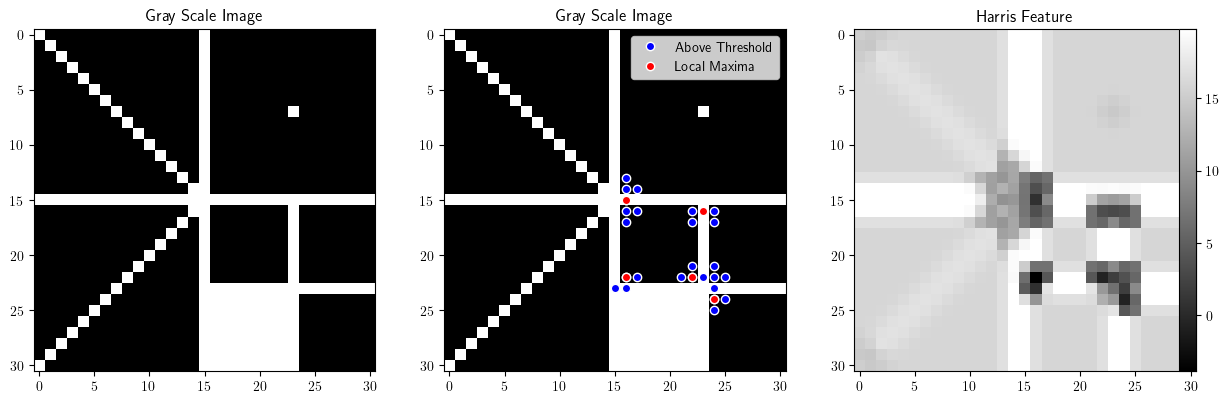

In [8]:
#%% Harris Detection Statistic
# Note how easy it is to calculate the figure of merit since we have A, B, and C
# already calculated at each pixel location 

trace       = A+B
determinant = A*B - C**2

k = 0.06

harris  = determinant - k*np.square(trace)
dilated = cv.dilate(harris,np.ones((5,5))) # Dilate to find local maxima

threshold = np.percentile(harris,95)
print('Threshold: %5.3f' % threshold)

figure = plt.figure(figsize=(FIGURE_WIDTH,FIGURE_WIDTH))
figure.clf()

axes = figure.add_subplot(131)
axes.imshow(image,cmap='gray', vmin=0, vmax=1)
axes.set_title('Gray Scale Image')

axes = figure.add_subplot(132)
axes.imshow(image,cmap='gray', vmin=0, vmax=1)
for c,pt in enumerate(zip(*np.where((harris>0.5*harris.max())))):
    if c==0:
        label = 'Above Threshold'
    else:
        label = None
    axes.plot(pt[1],pt[0],color='b',marker='.',markersize=12,markeredgecolor='w',markeredgewidth=1.0,linestyle='None',label=label)        
for c,pt in enumerate(zip(*np.where((harris==dilated) & (harris>0.5*harris.max())))):
    if c==0:
        label = 'Local Maxima'
    else:
        label = None
    axes.plot(pt[1],pt[0],color='r',marker='.',markersize=12,markeredgecolor='w',markeredgewidth=1.0,linestyle='None',label=label)
axes.set_title('Gray Scale Image')
axes.legend()

axes = figure.add_subplot(133)
axes.imshow(harris,cmap='gray_r',vmin=np.percentile(harris, 5), vmax=harris.max())
axes.set_title('Harris Feature')
add_colorbar(axes)
#pcv.AddColorbar(axes,colorMap='gray_r')

plt.show()

## Minimum Eigenvalue
* Alternatively, we could ask what direction $(x,y)$ results in the smallest increase in error
* This turns out to be in the direction of the smallest eigenvalue
* For a $2 \times 2$ matrix, this turns out to be the solution to a quadratic polynomial

\begin{equation*}
    \lambda^2 - (A+B) \lambda + (AB - C^2) = 0
    \hspace{100em}
\end{equation*}

which has solutions of

\begin{align*}
    \lambda &= \frac{(A+B) \pm \sqrt{(A+B)^2 - 4 (AB-C^2)}}{2} \\
    &= \frac{(A+B) \pm \sqrt{A^2 + 2AB + B^2 - 4AB + 4C^2}}{2} \\
    &= \frac{(A+B) \pm \sqrt{A^2 - 2AB + B^2 + 4C^2}}{2} \\
    &= \frac{(A+B) \pm \sqrt{(A-B)^2 + 4C^2}}{2}    
    \hspace{100em}
\end{align*}

Note that the term in the square root will always be positive and hence the eigenvalues will be real (although the sign is arbitrary). This works out to

\begin{align}
    \lambda_{\min} = \frac{(A+B) - \sqrt{(A-B)^2 +4C^2}}{2}
    \hspace{100em}
\end{align}

\begin{align}
    E(x,y) &= 
    \begin{bmatrix} 
        x & y 
    \end{bmatrix}
    \begin{bmatrix} 
        A & C \\ 
        C & B 
    \end{bmatrix}
    \begin{bmatrix} 
        x \\ 
        y 
    \end{bmatrix}
    =  
    \begin{bmatrix} 
        x & y 
    \end{bmatrix}
    M
    \begin{bmatrix} 
        x \\ 
        y 
    \end{bmatrix}
    \hspace{100em}
\end{align}

And 

\begin{align}
    \min_{x,y: \sqrt{x^2 + y^2} = 1} E(x,y) &=  v_{\min}^{T} M v_{\min} = v_{\min}^{T} \lambda_{\min} v_{\min} = \lambda_{\min}
    \hspace{100em}
\end{align}

* Hence $\lambda_{\min}$ is another promising figure of merit for ``corners''
* However, it requires a square root calculation at every pixel value
* This makes it considerably slower than Harris' figure of merit

### Ratio of Eigenvalues
* Alternatively, one could look at the ratio of eigenvalues
* You want them both to be large, so the ratio shouldn't be too different
* Ratios closer to 1 should be better
* This was discossed in Lowe's 2004 article on SIFT
* However, the ratio could be close to 1 if both eigenvalues are small, so this is perhaps a necessary, rather than a sufficient condition for a corner
* Lowe suggested this merely as a way to eliminate sensitivity to edges

Threshold: 1.971


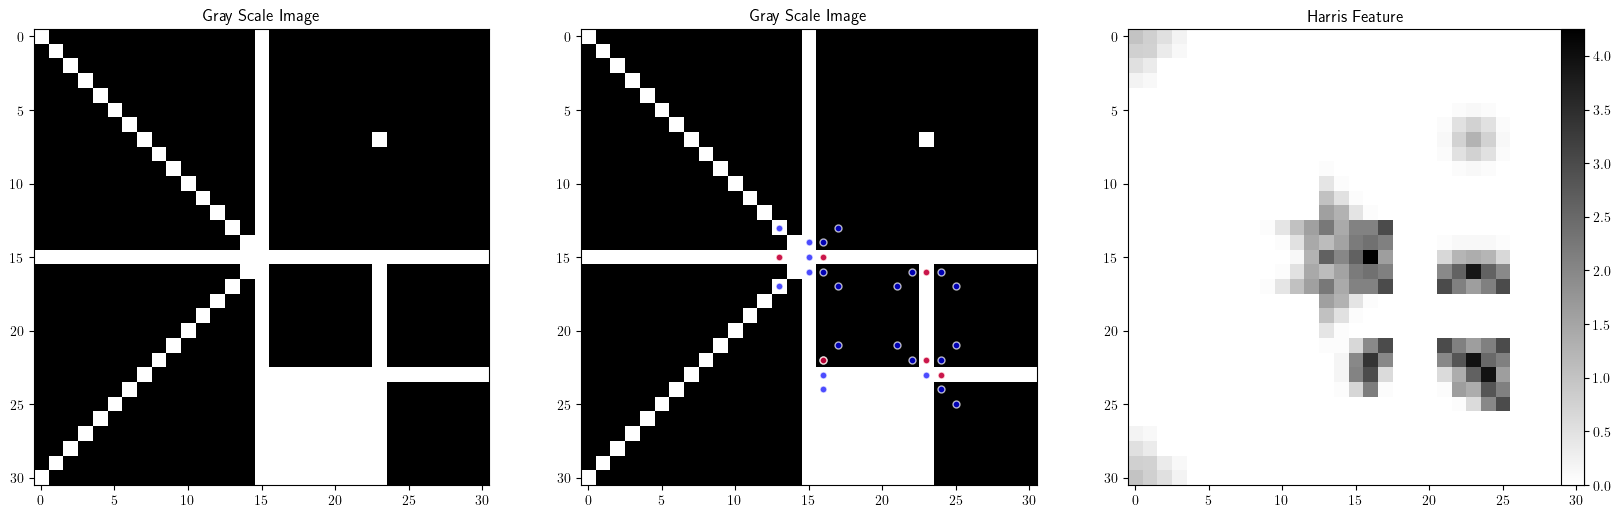

In [9]:
#%% Minimum Eigenvalue - Test Image Demonstration
trace       = A+B
determinant = A**2 - 2*A*B + B**2 - 4*C**2
lambdaMin = abs(((A+B) - np.sqrt((A-B)**2 + 4*C**2))/2) 
dilated   = cv.dilate(lambdaMin,np.ones((5,5)))

threshold = np.percentile(lambdaMin,95)
print('Threshold: %5.3f' % threshold)

figure = plt.figure()
figure.set_size_inches(20,20)
figure.clf()

axes = figure.add_subplot(131)
axes.imshow(image,cmap='gray', vmin=0, vmax=1)
axes.set_title('Gray Scale Image')

axes = figure.add_subplot(132)
axes.imshow(image,cmap='gray', vmin=0, vmax=1)
for pt in zip(*np.where((lambdaMin>0.5*lambdaMin.max()))):
    axes.plot(pt[1],pt[0],color='b',marker='.',markersize=10,alpha=0.7,linestyle='None',markeredgecolor='w',markeredgewidth=1.0)
for pt in zip(*np.where((lambdaMin==dilated) & (lambdaMin>0.5*lambdaMin.max()))):
    axes.plot(pt[1],pt[0],color='r',marker='.',markersize=10,alpha=0.7,linestyle='None',markeredgecolor='w',markeredgewidth=1.0)
axes.set_title('Gray Scale Image')

axes = figure.add_subplot(133)
axes.imshow(lambdaMin,cmap='gray_r',vmin=np.percentile(lambdaMin, 5), vmax=lambdaMin.max())
axes.set_title('Harris Feature')
pcv.AddColorbar(axes,colorMap='gray_r')

plt.show()

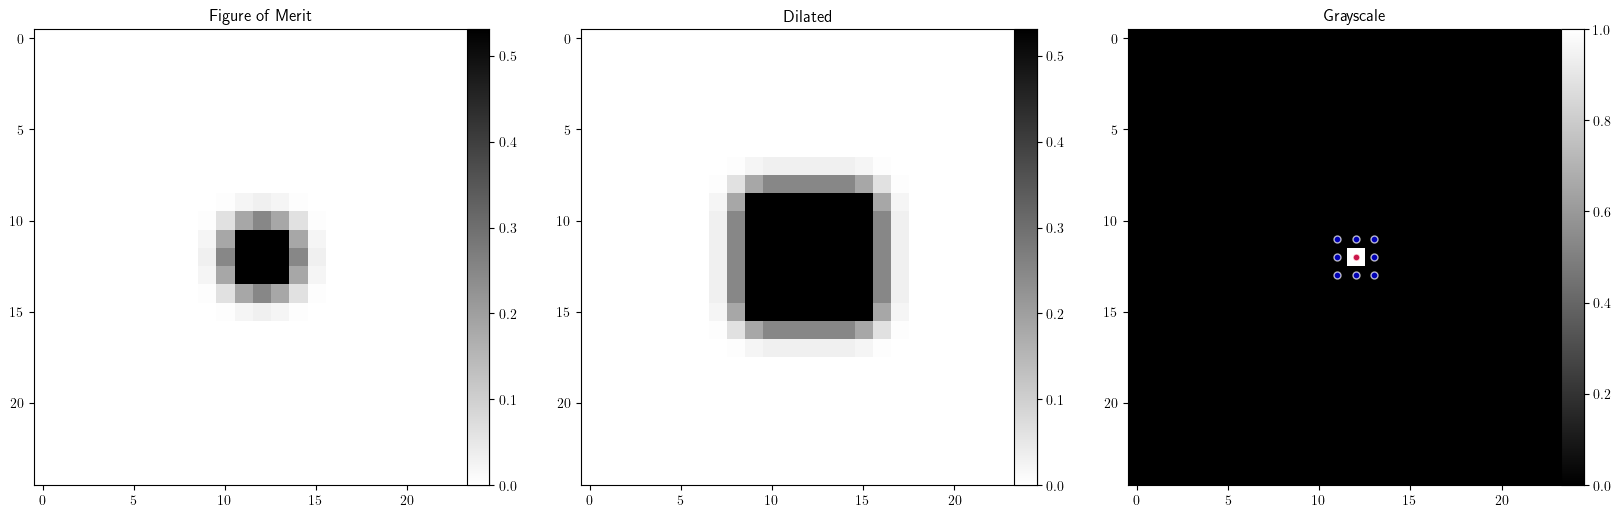

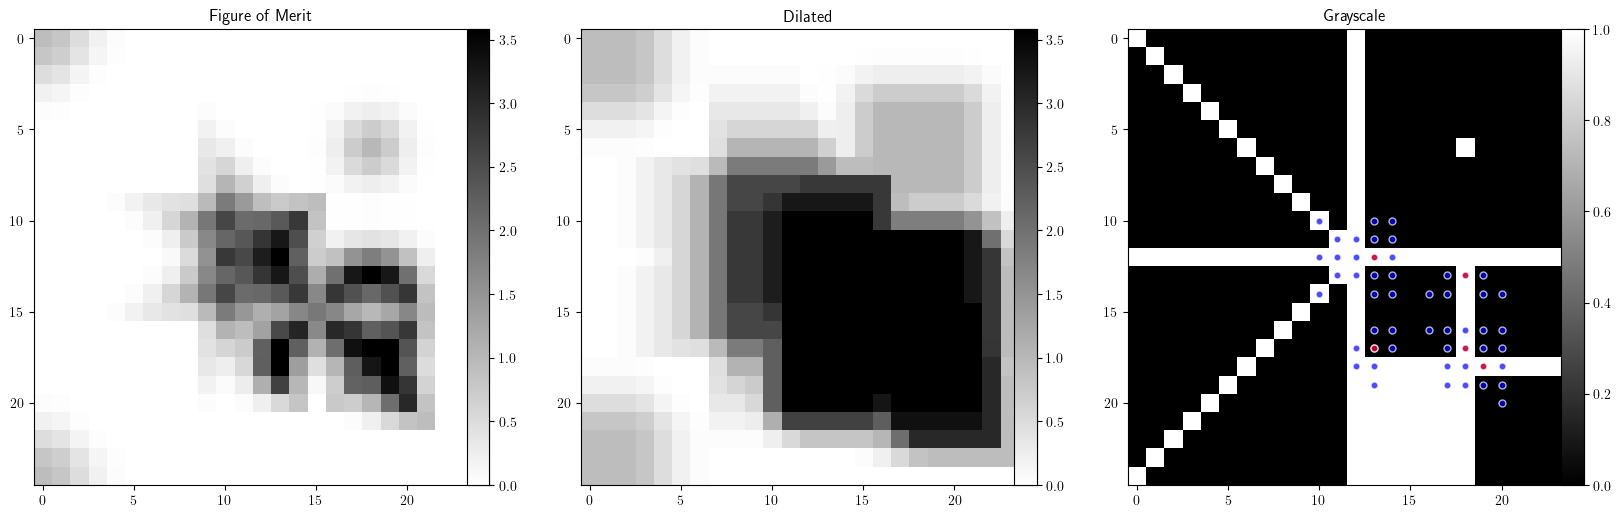

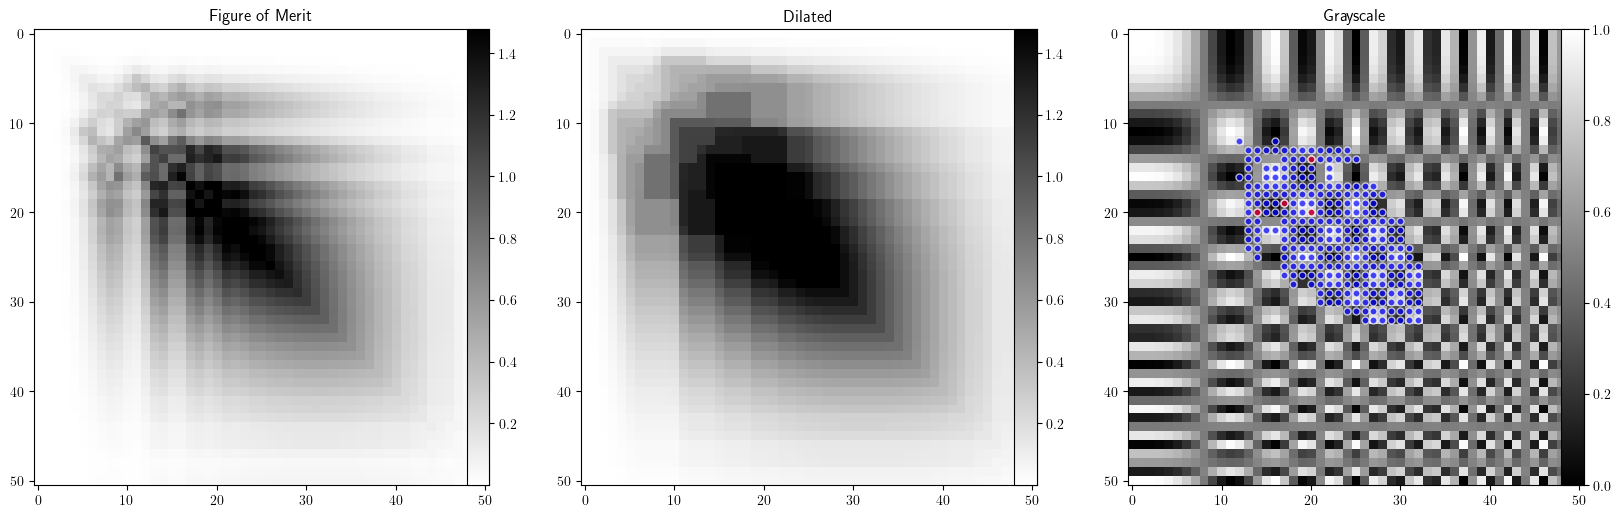

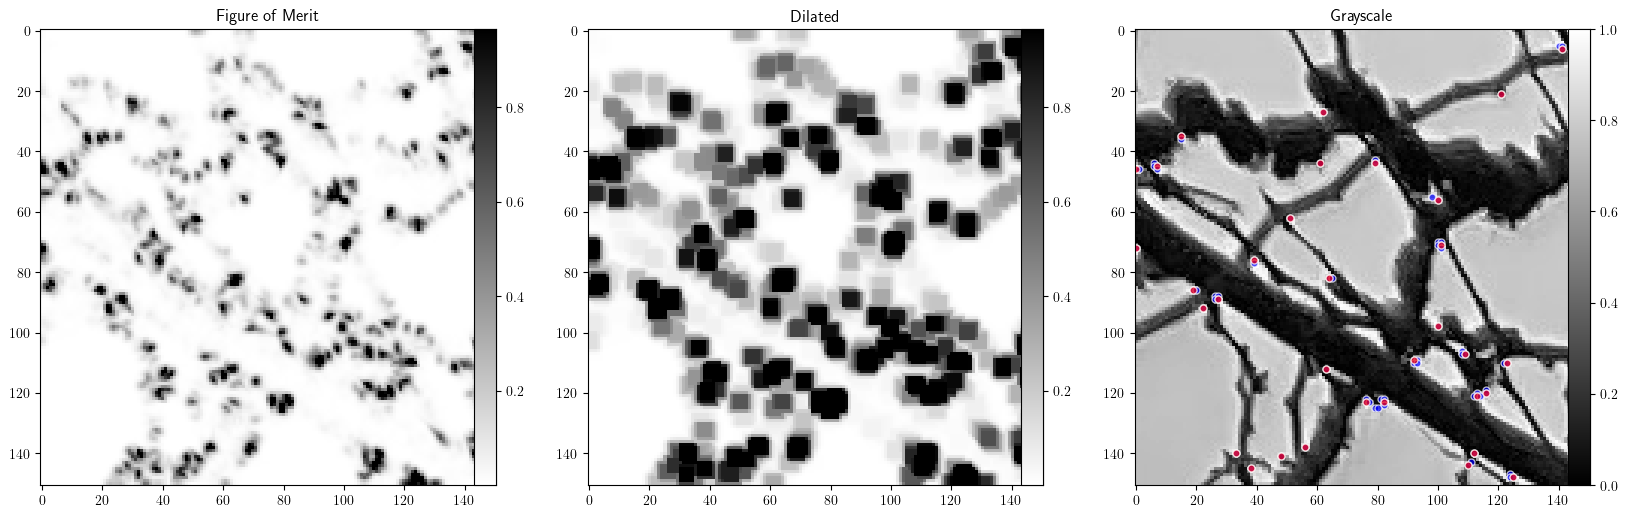

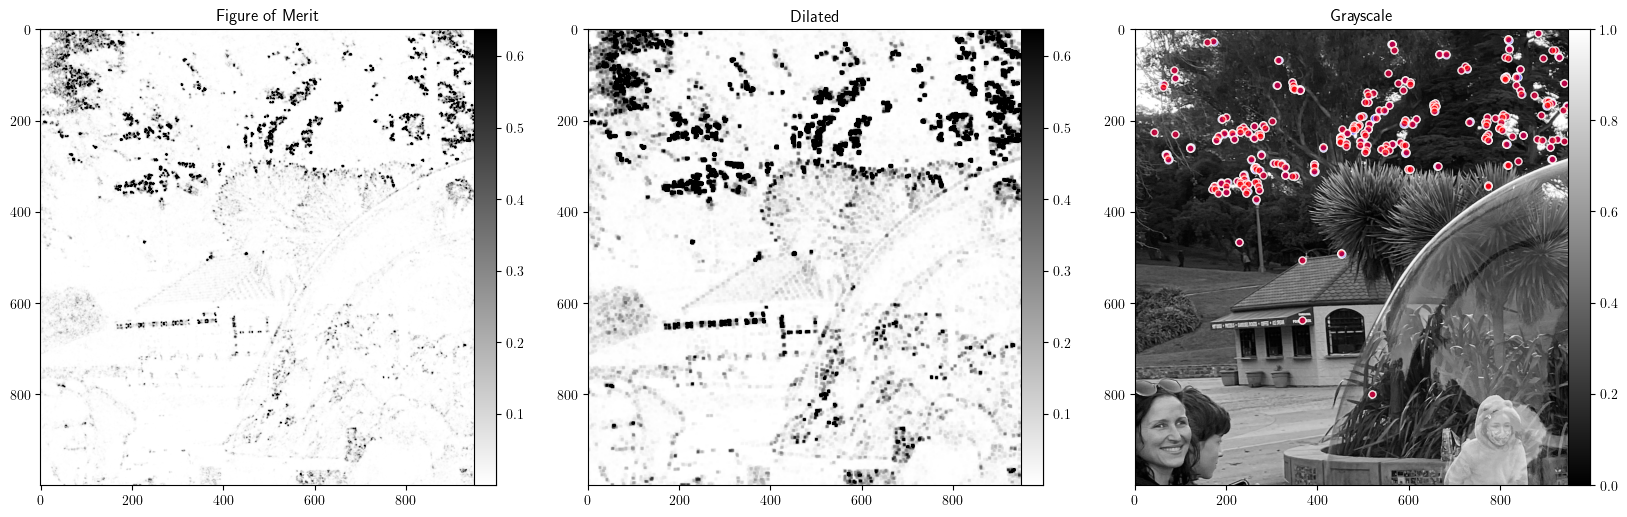

In [13]:
#%% Minimum Eigenvalue - Show for Variety of Images
images = pcv.GetDemoImages()
#images = images[:4]

for image in images:
    #fom     = cv.cornerHarris(image,blockSize,ksize,k)
    fom     = pcv.GetMinEigenvalues(image,blockSize=5)
    dilated = cv.dilate(fom,np.ones((5,5)))
    
    figure = plt.figure()
    figure.clf()
    figure.set_size_inches(20,15)
    
    axes = figure.add_subplot(131)
    axes.imshow(fom,cmap='gray_r',vmin=np.percentile(fom, 5), vmax=np.percentile(fom,99))
    axes.set_title('Figure of Merit')
    pcv.AddColorbar(axes,colorMap='gray_r')
    
    axes = figure.add_subplot(132)
    axes.imshow(dilated,cmap='gray_r',vmin=np.percentile(fom, 5), vmax=np.percentile(fom,99))
    axes.set_title('Dilated')
    pcv.AddColorbar(axes,colorMap='gray_r')
    
    axes = figure.add_subplot(133)
    axes.imshow(image,cmap='gray')
    for pt in zip(*np.where((fom>0.5*fom.max()))):
        axes.plot(pt[1],pt[0],color='b',marker='.',markersize=10,alpha=0.7,linestyle='None',markeredgecolor='w',markeredgewidth=1.0)
    for pt in zip(*np.where((fom==dilated) & (fom>0.5*fom.max()))):
        axes.plot(pt[1],pt[0],color='r',marker='.',markersize=10,alpha=0.7,linestyle='None',markeredgecolor='w',markeredgewidth=1.0)
    axes.set_title('Grayscale')
    pcv.AddColorbar(axes)

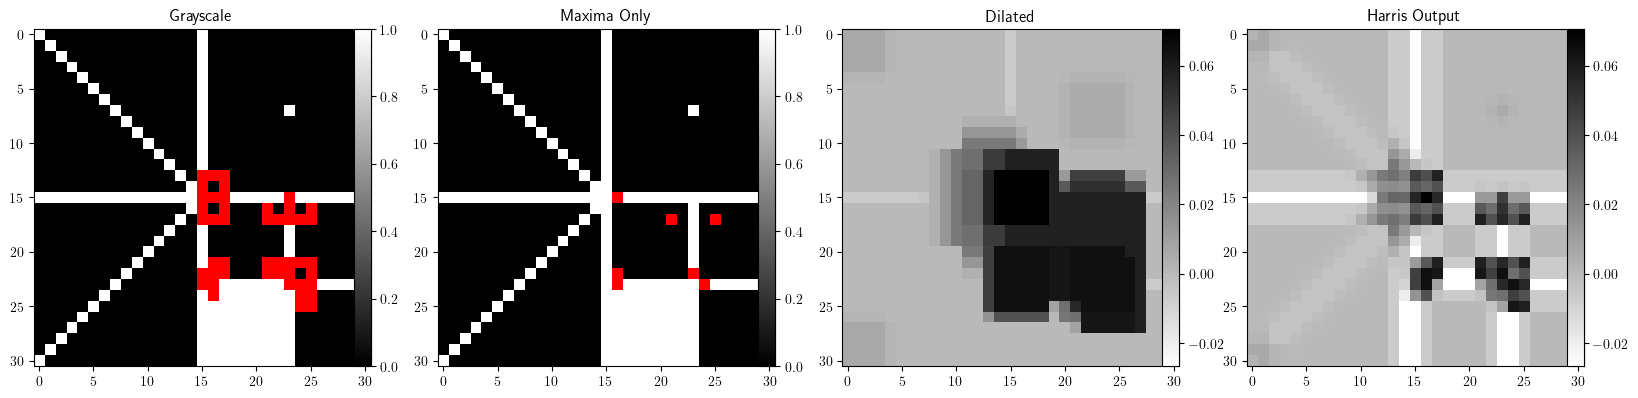

In [11]:
#%% OpenCVs Version of Harris
#blockSize = 1
ksize = 3 # Try to make same as above
# k = Harris detector free parameter

image = pcv.GetTestImage(nPixelsPerSide=31)
#image = pcv.GetChirpImage()

# Results may be a bit different than above because this
# doesn't seem to use a Gaussian blur
dst = cv.cornerHarris(image,blockSize,ksize,k)

# Threshold for an optimal value, it may vary depending on the image.
imageGray = cv.cvtColor(image,cv.COLOR_GRAY2RGB) # Convert to RGB
imageHarris = imageGray.copy()
imageHarris[dst>0.5*dst.max()]=[1,0,0]

dilated  = cv.dilate(dst,np.ones((5,5)))
maxmask = (dst==dilated) & (dst>0.5*dst.max())
maximaOnly = imageGray.copy() #cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
maximaOnly[maxmask] =[1,0,0]

#dst = dst - np.percentile(dst, 5)
#dst = dst/np.percentile(dst,99)

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,15)

axes = figure.add_subplot(141)
axes.imshow(imageHarris,cmap='gray')
axes.set_title('Grayscale')
pcv.AddColorbar(axes)

axes = figure.add_subplot(142)
axes.imshow(maximaOnly,cmap='gray')
axes.set_title('Maxima Only')
pcv.AddColorbar(axes)

axes = figure.add_subplot(143)
axes.imshow(dilated,cmap='gray_r',vmin=np.percentile(dst, 5), vmax=dst.max())
axes.set_title('Dilated')
pcv.AddColorbar(axes,colorMap='gray_r')

axes = figure.add_subplot(144)
axes.imshow(dst,cmap='gray_r',vmin=np.percentile(dst, 5), vmax=dst.max())
axes.set_title('Harris Output')
pcv.AddColorbar(axes,colorMap='gray_r')

plt.show()

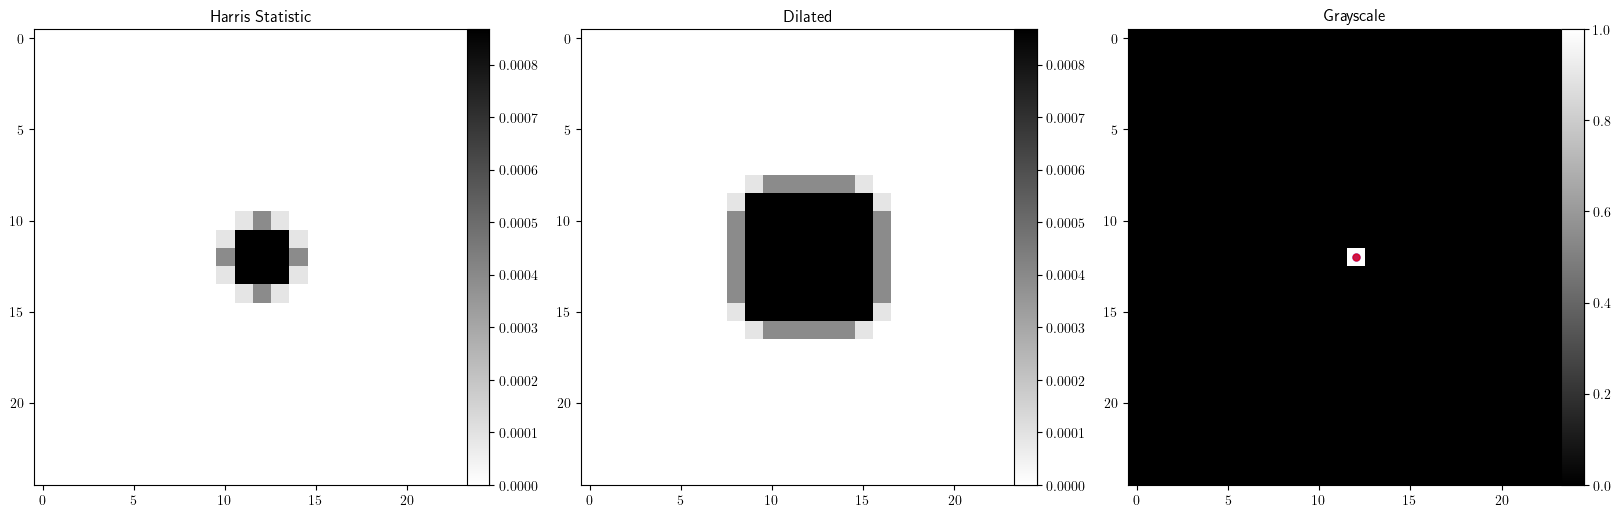

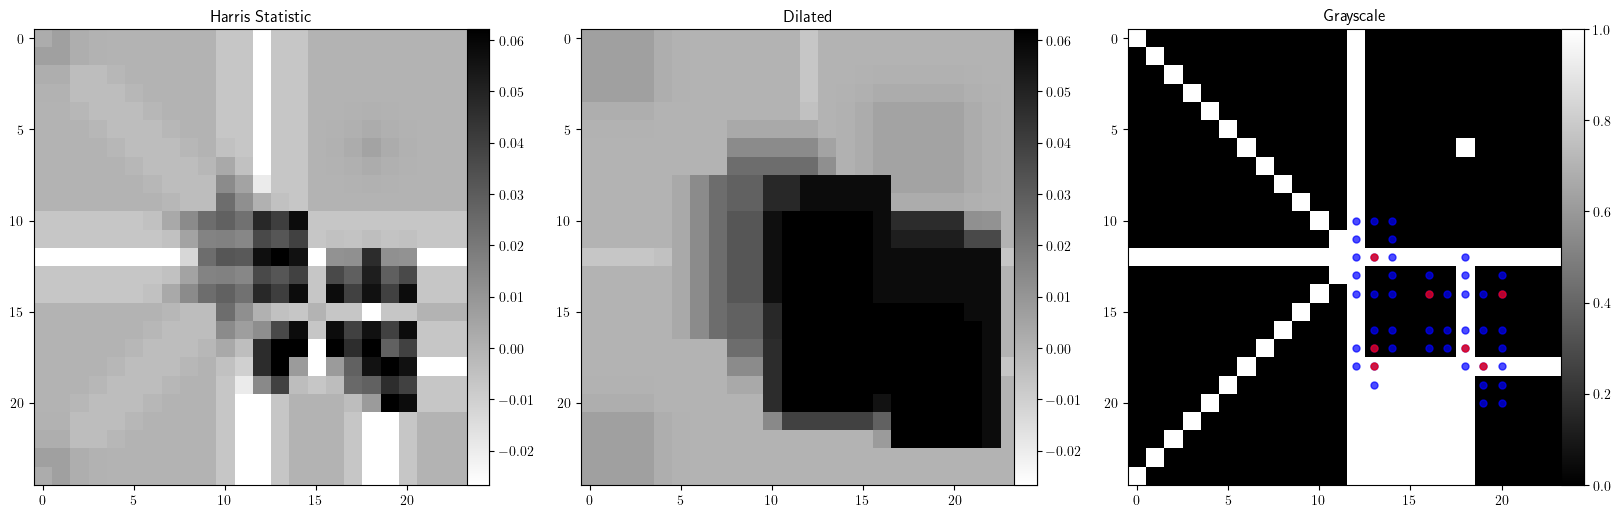

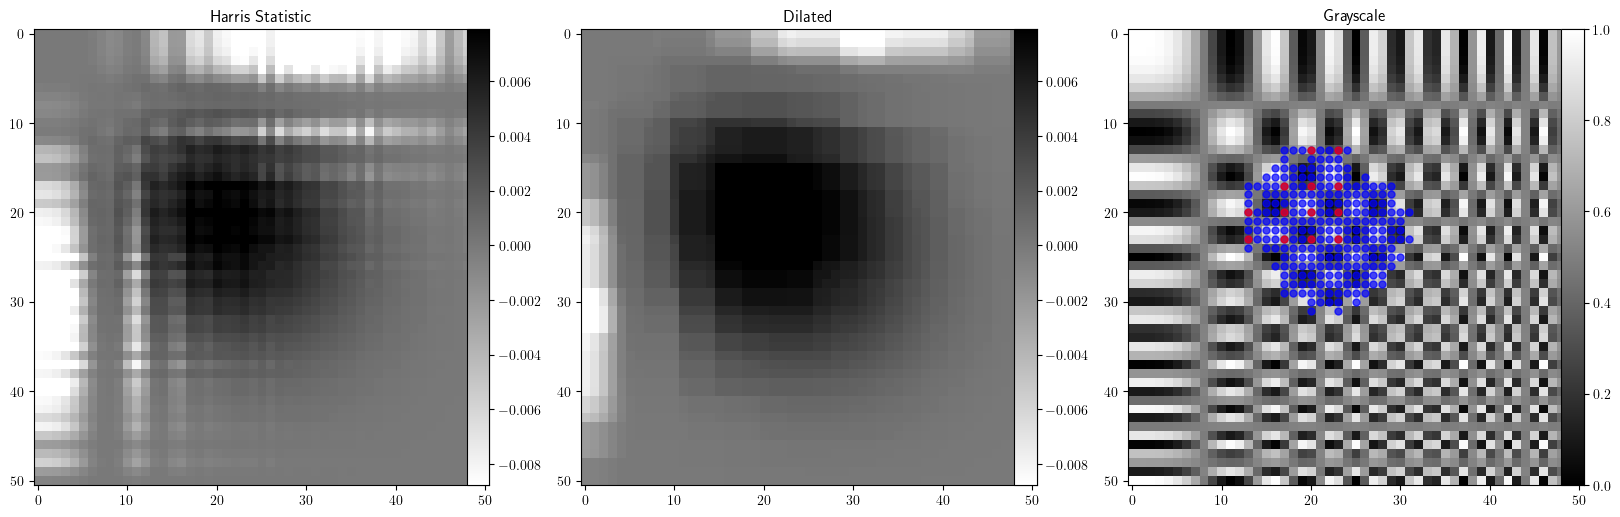

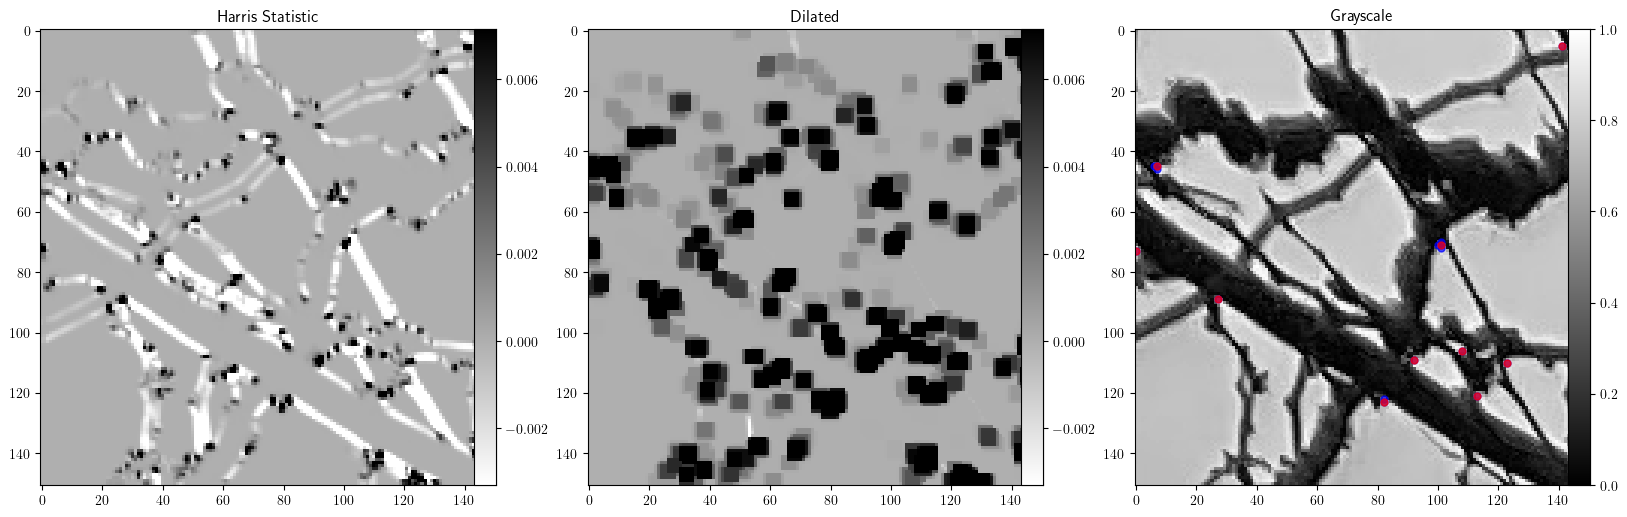

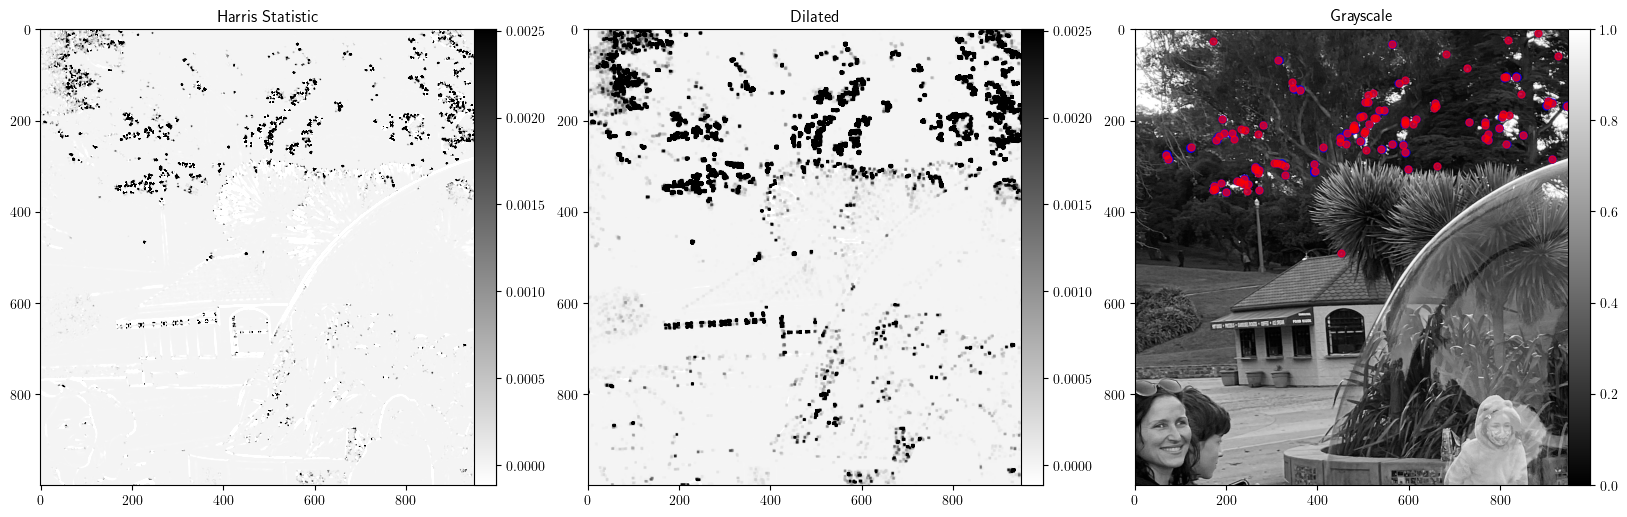

In [12]:
# OpenCV's version of Harris corner detectors
images = pcv.GetDemoImages()

for image in images:
    dst     = cv.cornerHarris(image,blockSize,ksize,k)
    dilated = cv.dilate(dst,np.ones((5,5)))
    
    figure = plt.figure()
    figure.clf()
    figure.set_size_inches(20,15)
    
    axes = figure.add_subplot(131)
    axes.imshow(dst,cmap='gray_r',vmin=np.percentile(dst, 5), vmax=np.percentile(dst,99))
    axes.set_title('Harris Statistic')
    pcv.AddColorbar(axes,colorMap='gray_r')
    
    axes = figure.add_subplot(132)
    axes.imshow(dilated,cmap='gray_r',vmin=np.percentile(dst, 5), vmax=np.percentile(dst,99))
    axes.set_title('Dilated')
    pcv.AddColorbar(axes,colorMap='gray_r')
    
    axes = figure.add_subplot(133)
    axes.imshow(image,cmap='gray')
    for pt in zip(*np.where((dst>0.5*dst.max()))):
        axes.plot(pt[1],pt[0],color='b',marker='.',markersize=10,alpha=0.7)
    for pt in zip(*np.where((dst==dilated) & (dst>0.5*dst.max()))):
        axes.plot(pt[1],pt[0],color='r',marker='.',markersize=10,alpha=0.7)
    axes.set_title('Grayscale')
    pcv.AddColorbar(axes)

    plt.show()

### Variations

* See the text
* Eigenvalues may be better than using the determinant and trace
* Arguments about square root, but unclear to me how important this is
* Perhaps
\begin{equation*}
    \lambda_0 - \alpha \lambda_1
    \hspace{100em}
\end{equation*}
* Also maybe harmonic mean
\begin{equation*}
    \frac{\mathrm{det}(M)}{\mathrm{tr}(M)} = \frac{\lambda_0 \lambda_1}{\lambda_0 + \lambda_1}
    \hspace{100em}
\end{equation*}
* May also want to suppress neighbors for some radius